![alt text](https://storage.googleapis.com/pr-newsroom-wp/1/2018/11/Spotify_Logo_CMYK_Green.png)

## Comparing Supervised & Unsupervised Learning Methods to Identify Songs for Spotify Playlists
-Jeremy Seibert

Spotify is an amazing music streaming service that touches over 200 million customers. This notebook is the exploration between two playlists, one filled with songs that are liked, and the other filled with songs that are disliked. These playlists are populated with songs built around my song preferences. Our goal here will be to use some fancy machine learning, to predict whether songs will be liked, and which songs will be disliked, based on the two aforementioned playlists.

I aggregated the Spotify track data that we will be using in this notebook, by using an awesome package called SpotiPy. SpotiPy is a Python wrapper built for Spotify's API. As with most APIs, you’re required for authentication purposes to supply a client and secret ID. For this reason I will not be showing you in this notebook the exact methodology to gather these exact playlists, and I have simply supplied the information via a csv file. 

That said, I have put together a separate notebook outlining the process of using SpotiPy and how to access Spotify Data [here](https://github.com/Jaseibert/Spotipy_and_Spotify_API). 

### 1. We begin with the necessities

We will start the notebook off by importing the data into a Pandas DataFrame called **total_data**. We can use the Pandas `df.loc` method to subset the total_data DataFrame into songs which are liked, as noted by a 1, and songs which are disliked, denoted by 0. 

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Import the Dataset
total_data = pd.read_csv('./Dataset/total_data.csv')
total_data.head()

# Subset the liked and disliked songs
disliked_songs = total_data.loc[total_data["target"] == 0]
liked_songs = total_data.loc[total_data["target"] == 1]

### 2. Numerical EDA

Let us begin by taking a look at the information that we have collected. For each song that Spotify has, they derive a series of metrics that describe the song. The descriptions of these metrics can be found [here](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/). Below we can see the distribution of the metrics from the songs in the two playlists. 


In [3]:
total_data.describe()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,target,tempo,time_signature,valence
count,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000,427.000000
mean,0.158086,0.616323,225362.634660,0.709520,0.014489,5.173302,0.185300,-6.044801,0.594848,0.082004,0.655738,121.992496,3.962529,0.537900
std,0.195572,0.134552,52364.684139,0.160338,0.080775,3.604632,0.137736,2.616608,0.491497,0.080011,0.475684,29.458095,0.244183,0.213176
min,0.000029,0.256000,101790.000000,0.161000,0.000000,0.000000,0.034100,-22.320000,0.000000,0.024400,0.000000,51.316000,1.000000,0.039700
25%,0.021000,0.531000,195393.500000,0.605000,0.000000,2.000000,0.094300,-7.039500,0.000000,0.037100,0.000000,98.081000,4.000000,0.388000
50%,0.070900,0.619000,216373.000000,0.731000,0.000000,6.000000,0.134000,-5.492000,1.000000,0.050600,1.000000,120.046000,4.000000,0.543000
75%,0.230000,0.713000,243492.000000,0.832000,0.000050,8.000000,0.240500,-4.465500,1.000000,0.085300,1.000000,140.707500,4.000000,0.686000
max,0.883000,0.980000,720186.000000,0.997000,0.836000,11.000000,0.882000,-0.698000,1.000000,0.481000,1.000000,215.894000,5.000000,0.969000


### 3. Visual EDA

Let us use the seaborn distribution plot to visualize the feature distribution differences between the liked songs and the disliked songs. We do this with the help of several functions, that give us the ability to either visualize the distribution of just one feature or all of the features. We decide which option to visualize within the first input prompt. The user chooses “all” if they want to visualize all of the features, and the user chooses “one” if there is one specifically that is wanted to be visualized. If “one” is selected the user chooses and enters one of the following features to be visualized. 

('acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'time_signature', 'valence') 



In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

Do you want to visualize all of the features or select a specific one?(all/one):  one
What feature's distributions do you want to look at?:  acousticness


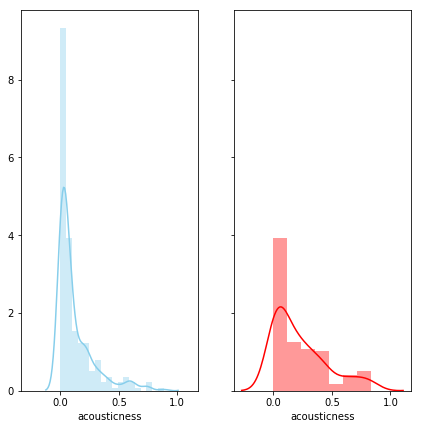

In [6]:
def create_distplot(*argv):
    '''This function takes any number of features and returns 2 sns.distplots for the feature in the liked and disliked df.'''
    for arg in argv:
        f, axes = plt.subplots(1,2,figsize=(7, 7), sharex=True,sharey=True)
        sns.distplot( liked_songs[str(arg)], color="skyblue", ax=axes[0])
        sns.distplot( disliked_songs[str(arg)] , color="red", ax=axes[1])
    return
    
def define_features_to_show(all=False):
    '''This function takes a user input to dictate the feature that the sns.distplot shows'''
    if all is True:
        create_distplot('acousticness','danceability','energy','instrumentalness',
                        'liveness','loudness','speechiness','valence')
    else: 
        feature = str(input("What feature's distributions do you want to look at?: "))
        create_distplot(feature)
    return

def show_plots():
    choice = str(input("Do you want to visualize all of the features or select a specific one?(all/one): "))
    if choice == 'all':
        define_features_to_show(all=True)
    else: 
        define_features_to_show()
    return

show_plots()

### 4. Preform Pre-Processing 


In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [8]:
#Define our Training & Target Features
train_features = total_data.drop(columns=['analysis_url','id','track_href','type','uri','target','key'],axis=1)
labels = total_data['target']

Text(0.5, 0, 'Principal Component #')

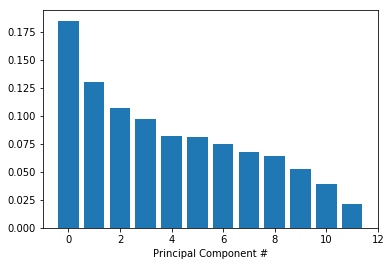

In [9]:
scaler = StandardScaler()
scaled_train_features = scaler.fit_transform(train_features)

# Get our explained variance ratios from PCA using all features
pca = PCA()
pca.fit(scaled_train_features)
exp_variance = pca.explained_variance_ratio_

# plot the explained variance using a barplot
fig, ax = plt.subplots()
ax.bar(range(pca.n_components_), exp_variance)
ax.set_xlabel('Principal Component #')

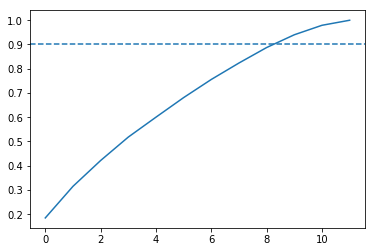

In [11]:
# Calculate the cumulative explained variance
cum_exp_variance = np.cumsum(exp_variance)

# Plot the cumulative explained variance and draw a dashed line at 90%
fig, ax = plt.subplots()
ax.plot(range(12),cum_exp_variance)
ax.axhline(y=0.9, linestyle='--')

In [12]:
#The first 9 Principle Components explain 90% of the variance
n_components = 8

# Perform PCA with the chosen number of components and project data onto components
pca = PCA(n_components, random_state=10)
pca.fit(scaled_train_features)
pca_projection = pca.transform(scaled_train_features)

### 5. Model Selection and Implementation

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
# Split our data
train_features, test_features, train_labels, test_labels = train_test_split(pca_projection, labels, random_state=10)

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

In [16]:
# Train our decision tree
tree = DecisionTreeClassifier(random_state=10)
tree.fit(train_features, train_labels)
pred_labels_tree = tree.predict(test_features)

# Train our logistic regression
logreg = LogisticRegression(random_state=10)
logreg.fit(train_features, train_labels)
pred_labels_logit = logreg.predict(test_features)

# Train our KNeighbors on the balanced data
knn = KNeighborsClassifier(3)
knn.fit(train_features, train_labels)
pred_labels_knn = knn.predict(test_features)

# Create the classification report for both models
from sklearn.metrics import classification_report
class_rep_tree = classification_report(test_labels, pred_labels_tree)
class_rep_log = classification_report(test_labels, pred_labels_logit)
class_rep_knn = classification_report(test_labels, pred_labels_knn)

print("Decision Tree: \n", class_rep_tree)
print("Logistic Regression: \n", class_rep_log)
print("KNearest Neighbors: \n", class_rep_knn)

Decision Tree: 
              precision    recall  f1-score   support

          0       0.37      0.49      0.42        35
          1       0.70      0.60      0.65        72

avg / total       0.60      0.56      0.57       107

Logistic Regression: 
              precision    recall  f1-score   support

          0       0.55      0.46      0.50        35
          1       0.76      0.82      0.79        72

avg / total       0.69      0.70      0.69       107

KNearest Neighbors: 
              precision    recall  f1-score   support

          0       0.45      0.40      0.42        35
          1       0.72      0.76      0.74        72

avg / total       0.63      0.64      0.64       107



### 6. Model Adjustment

In [17]:
# Subset only the bad songs
not_only = total_data.loc[total_data["target"] == 0]

# sample the Good songs to be the same number as there are in the bad songs
like_only = total_data.loc[total_data["target"] == 1].sample(len(not_only), random_state=10)

# concatenate the dataframes good and bad
not_like_bal = pd.concat([not_only, like_only])

# The features, labels, and pca projection are created for the balanced dataframe
track_features = not_like_bal.drop(columns=['analysis_url','id','track_href','type','uri','target'],axis=1)
labels = not_like_bal['target']
pca_projection = pca.fit_transform(scaler.fit_transform(track_features))

# Redefine the train and test set with the pca_projection from the balanced data
train_features, test_features, train_labels, test_labels = train_test_split(pca_projection, labels, random_state=10)

In [18]:
# Train our decision tree on the balanced data
tree = DecisionTreeClassifier(random_state=10)
tree.fit(train_features, train_labels)
pred_labels_tree = tree.predict(test_features)

# Train our logistic regression on the balanced data
logreg = LogisticRegression(random_state=10)
logreg.fit(train_features, train_labels)
pred_labels_logit = logreg.predict(test_features)

# Train our KNeighbors on the balanced data
knn = KNeighborsClassifier(3)
knn.fit(train_features, train_labels)
knn_pred = knn.predict(test_features)

# Compare the models
print("Decision Tree: \n", classification_report(test_labels, pred_labels_tree))
print("Logistic Regression: \n", classification_report(test_labels, pred_labels_logit))
print("KNN: \n", classification_report(test_labels, knn_pred))

Decision Tree: 
              precision    recall  f1-score   support

          0       0.38      0.47      0.42        30
          1       0.57      0.48      0.52        44

avg / total       0.49      0.47      0.48        74

Logistic Regression: 
              precision    recall  f1-score   support

          0       0.49      0.67      0.56        30
          1       0.70      0.52      0.60        44

avg / total       0.61      0.58      0.58        74

KNN: 
              precision    recall  f1-score   support

          0       0.49      0.77      0.60        30
          1       0.74      0.45      0.56        44

avg / total       0.64      0.58      0.58        74



### 7. KFold Cross-Validation

In [24]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [25]:
# Set up our K-fold cross-validation
kf = KFold(n_splits=10, random_state=10)

tree = DecisionTreeClassifier(random_state=10)
logreg = LogisticRegression(random_state=10)
knn = KNeighborsClassifier(3)

# Train our models using KFold cv
tree_score = cross_val_score(tree, pca_projection, labels, cv=kf)
logit_score = cross_val_score(logreg, pca_projection, labels, cv=kf)
knn_score = cross_val_score(knn, pca_projection, labels, cv=kf)

# Print the mean of each array of scores
print("Decision Tree:", np.mean(tree_score), "Logistic Regression:", np.mean(logit_score), "KNN:", np.mean(knn_score))

Decision Tree: 0.5171264367816091 Logistic Regression: 0.588735632183908 KNN: 0.48298850574712643


## Conclusion